## Predicting Income with Random Forests

Codeacademy project to predict whether or not a person earns over $50,000, using [UCL ML Repository Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/census%20income).

Dataset description:  
        e-mail: ronnyk@sgi.com for questions.  
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).  
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)  
| 45222 if instances with unknown values are removed (train=30162, test=15060)  
| Duplicate or conflicting instances : 6  
| Class probabilities for adult.all file  
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)  
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)


In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

### Get data

In [5]:
# establish data source

adult_data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# set columns names
columnnames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# create dataframes

adult_data = pd.read_csv(adult_data_url, names=columnnames, delimiter=", ")
adult_test = pd.read_csv(adult_test_url, names=columnnames, delimiter=", ", skiprows=1)

# print sizes
print('adult_data: {} \n\
adult_test: {}'
      .format(adult_data.shape, adult_test.shape))
    

adult_data: (32561, 15) 
adult_test: (16281, 15)


### Browse data

In [6]:
adult_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
adult_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [8]:
# merge datasets so can perform feature engineering and train/test split later
tomerge = [adult_data, adult_test]
data = pd.concat(tomerge)
data.shape

(48842, 15)

In [9]:
# data have been cleaned but check for null anyway
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

### Create features

In [10]:
# print datatypes
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [11]:
data.income.unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

Income needs attention as original test and train were formatted slightly differently.

Floats are ok, though may benefit from scaling.

A number are categorical and need converting to numerical:
- workclass, education, occupation, relationship, race, sex, native-country, income

In [12]:
# split off income as feature, and correct formatting
income = data.income.map({'<=50K': '<=50K', '<=50K.' : '<=50K', '>50K': '>50K', '>50K.': '>50K'}).tolist()

In [13]:
# generate df with income dropped
data_drop = data.drop('income', axis=1)

In [17]:
# OneHot encode categorical to numerical
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(data_drop.astype(str))

### Model data

In [36]:
# tune the model

# import prev function

def train_forests(data, labels, est, step):
    # split into train and test sets, random state for reproducibility
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.25, random_state = 1)
    
    # train model with i estimators

    scores = []
    topscores = []
    
    for i in range(step, est+step, step):
        clf = RandomForestClassifier(max_depth=i)
        clf.fit(train_data, train_labels)
        accuracy = clf.score(test_data, test_labels)
        scores.append([i, accuracy])
    
    # graph scores
    
    # extract estimators
    estimators = [x[0] for x in scores]

    # extract scores
    scores_only = [x[1] for x in scores]
    
    # report top scores
    for i, j in enumerate(scores_only):
        if j == max(scores_only):
            topscores.append([estimators[i], j])
    
    # define plot
    
    plt.figure(figsize=(12, 6))
    plt.plot(estimators, scores_only, 'b-')
    plt.xlabel('n estimators')
    plt.xticks(range(step, est+step, step), rotation='vertical')
    plt.ylabel('Accuracy on test data')
    plt.title('Plot for max_depth={}, step={}'.format(est, step))
    
    ymax = max(scores_only)
    xmax = estimators[scores_only.index(ymax)]
    text= "Best accuracy={:.3f} at depth={:d}, ".format(ymax, xmax)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    plt.annotate(text, xy=(xmax, ymax), xytext=(0.3,0.96), **kw)

    # output
    print("Best accuracy is {}, with depth {}".format(topscores[0][1], topscores[0][0]))
    plt.show()

Best accuracy is 0.8613545164196217, with depth 170


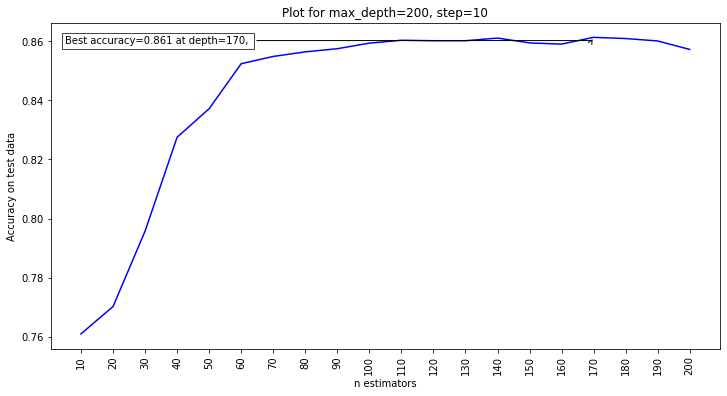

In [38]:
train_forests(data_encoded, income, 200, 10)

Best accuracy is 0.8597985422979281, with depth 150


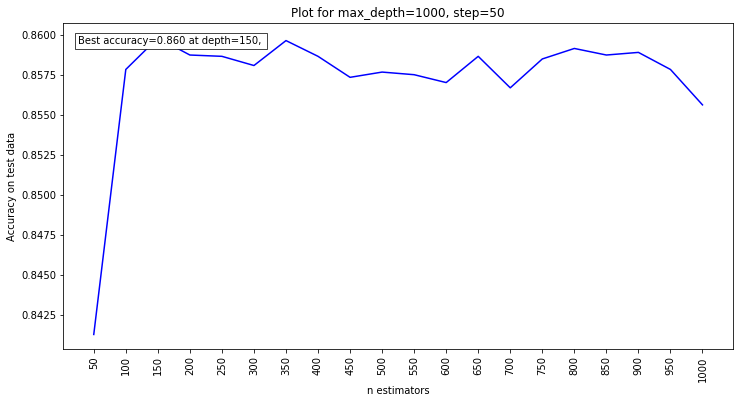

In [39]:
# try a higher range as looks like it was plateauing, but maybe still increasing?
train_forests(data_encoded, income, 1000, 50)

### Investigate

Best fit seems to be around 150, so I'll stick with the max_depth=170 from the first iteration.

In [41]:
# split data as per train_forests function
train_data, test_data, train_labels, test_labels = train_test_split(data_encoded, income, test_size = 0.25, random_state = 1)

# train model with max_depth = 1
clf_170 = RandomForestClassifier(max_depth=170)
clf_170.fit(train_data, train_labels)

print("Accuracy on test data {:.3f}".format(clf_16.score(test_data, test_labels)))

Accuracy on test data 0.764


In [42]:
# make predictions on test data
clf_170_predictions = clf_170.predict(test_data)

In [43]:
 # look at which features are most important
feats = []

for feat in enumerate(data_drop):
    feats.append([feat[1], clf_16.feature_importances_[feat[0]]])
best_feats = sorted(feats, key=lambda x : x[1], reverse=True)

best_feats

[['education', 0.0072961345707197485],
 ['education-num', 0.005058549522028987],
 ['marital-status', 0.0046524931648706195],
 ['workclass', 0.00423579065029625],
 ['race', 0.004123059900744092],
 ['capital-loss', 0.0023272646491192327],
 ['occupation', 0.002322248598420738],
 ['age', 0.0020082933286266905],
 ['relationship', 0.002001852678757225],
 ['fnlwgt', 0.0019462647027120323],
 ['capital-gain', 0.0013204482301494196],
 ['sex', 0.001179571470796223],
 ['hours-per-week', 0.0003948456663165891],
 ['native-country', 0.0002675343542176197]]

This wasn't especially informative, other that to imply don't have any especially standout features. I won't look into feature subsets further.

In [44]:
# import some metrics

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

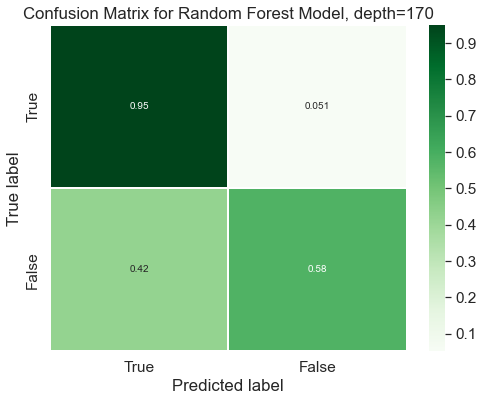

In [47]:
# plot confusion matrix using seaborn heatmap; based on https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595
import seaborn as sns

# Get and reshape confusion matrix data
matrix = confusion_matrix(test_labels, clf_170_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['True', 'False']
plt.xticks(ticks=[0.5, 1.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5], labels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model, depth=170')
plt.show()

In [49]:
# View the classification report for test data and predictions
print(classification_report(test_labels, clf_170_predictions))

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      9292
        >50K       0.78      0.58      0.66      2919

    accuracy                           0.86     12211
   macro avg       0.83      0.76      0.79     12211
weighted avg       0.85      0.86      0.85     12211



The heatmap shows most prediction of true values is good (95% or true values are predicted correctly, with only 5% false positives.  However, false negatives occur relatively often (42% of the time), meaning correctly prediction of negatives (here, earning >50K) is only 58%.  I will implement GridSearchCV, as outlined [here](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65) to see if this can be improved.

In [53]:
param_grid = {
    'n_estimators' : [3, 10, 30],
    'max_depth': [170],
    'max_features': [3, 8, 14]
}

In [54]:
# prep data
income_num = []
for x in income:
    if x == '>50K':
        income_num.append(1)
    if x != '>50K':
        income_num.append(0)

train_data2, test_data2, train_labels2, test_labels2 = train_test_split(data_encoded, income_num, test_size = 0.25, random_state = 1)

In [56]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_error', cv=skf)
grid_search.fit(train_data2, train_labels2)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [170], 'max_features': [3, 8, 14],
                         'n_estimators': [3, 10, 30]},
             scoring='neg_mean_squared_error')

In [57]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=170, max_features=14, n_estimators=3)

In [58]:
grid_search.best_score_

-0.2146817818215198

In [59]:
# train model using gridsearch optimisation
clf_best = RandomForestClassifier(max_depth=170, max_features=14, n_estimators=3)
clf_best.fit(train_data, train_labels)

print("Accuracy on test data {:.3f}".format(clf_best.score(test_data, test_labels)))

Accuracy on test data 0.775


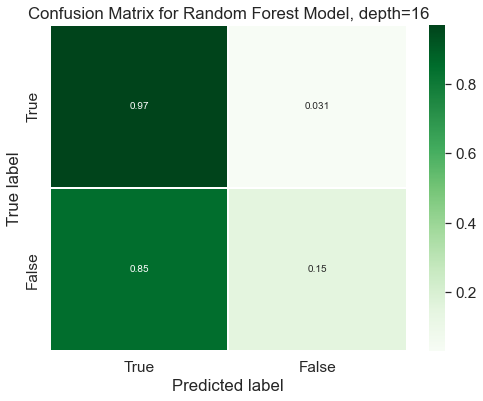

In [60]:
# make predictions on test data
clf_best_predictions = clf_best.predict(test_data)

# plot confusion matrix

# Get and reshape confusion matrix data
matrix = confusion_matrix(test_labels, clf_best_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['True', 'False']
plt.xticks(ticks=[0.5, 1.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5], labels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model, depth=16')
plt.show()

In [61]:
# View the classification report for test data and predictions
print(classification_report(test_labels, clf_best_predictions))

              precision    recall  f1-score   support

       <=50K       0.78      0.97      0.87      9292
        >50K       0.61      0.15      0.25      2919

    accuracy                           0.77     12211
   macro avg       0.70      0.56      0.56     12211
weighted avg       0.74      0.77      0.72     12211



This has made very little difference. The accuracy improved form 0.764 to 0.775 - neither as good as the 0.861 recorded in the initial